In [4]:
import pandas as pd
import numpy as np
import unicodedata
import statistics
import operator

from fuzzywuzzy import fuzz 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.decomposition import NMF

from SToC import *

import os

from IPython.display import HTML, display
from tabulate import tabulate
from metrics import Evaluation as Eval

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

/home/leandror/.local/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [1]:
import pickle
with open('document_dict.pickle', 'rb') as f:
    document_dict= pickle.load(f)

In [6]:
document_dict

{'software and its engineering': [20,
  48,
  51,
  55,
  70,
  71,
  74,
  99,
  123,
  128,
  130,
  131,
  134,
  136,
  144,
  147,
  188,
  211,
  261,
  284,
  286,
  302,
  307,
  327,
  382,
  401,
  407,
  474,
  478,
  485,
  502,
  503,
  538,
  548,
  549,
  550,
  551,
  571,
  575,
  599,
  604,
  611,
  668,
  690,
  701,
  704,
  711,
  722,
  741,
  743,
  752,
  789,
  813,
  835,
  855,
  856,
  857,
  869,
  886,
  903,
  912,
  943,
  959,
  1032,
  1041,
  1048,
  1079,
  1080,
  1081,
  1088,
  1094,
  1096,
  1097,
  1099,
  1104,
  1113,
  1114,
  1116,
  1133,
  1203,
  1239,
  1245,
  1246,
  1259,
  1278,
  1292,
  1339,
  1345,
  1346,
  1356,
  1391,
  1392,
  1399,
  1400,
  1464,
  1478,
  1497,
  1506,
  1554,
  1556,
  1566,
  1586,
  1599,
  1607,
  1628,
  1654,
  1656,
  1712,
  1713,
  1729,
  1734,
  1743,
  1753,
  1764,
  1784,
  1808,
  1861,
  1904,
  1909,
  1910,
  1935,
  1950,
  1966,
  2044,
  2051,
  2055,
  2066,
  2071,
  2079,
  2125,

In [5]:
df_artigos = pd.read_csv('../../datasets/artigos/preprocessed/without_spacy/artigos2017_pre',sep="|",index_col=0)

In [16]:
document_dict['software and its engineering']

144

In [32]:
def execute_tfidf(dataset,max_df=1,min_df=1,ngram=(0,2),stop_words=[]):
    tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df,ngram_range=ngram,stop_words=stop_words)
    tfidf = tfidf_vectorizer.fit_transform(dataset)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    return tfidf,tfidf_feature_names
def execute_nmf(tfidf,n_topics = 10,n_components = 5):
    n_topics = n_topics
    n_components = n_components
    nmf = NMF(n_components=n_components,max_iter=400)
    W = nmf.fit_transform(tfidf)
    H = nmf.components_.transpose() 
    return nmf,W,H
def print_top_words_display(H, feature_names, n_top_words):
    table_output = [['Topic','topwords']]
    topics = []
    for topic_idx, topic in enumerate(H):
        top_index = ["Topic # %d" % topic_idx]
        top_words = [" ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])]
        values = [value for value in np.sort(topic)[:-n_top_words - 1:-1]]
        table_output.append(top_index + top_words)
        topics.append(" ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
    df_out = pd.DataFrame(table_output, index=None)
    display(HTML(tabulate(table_output, tablefmt='html')))
    return topics,df_out

In [17]:
new_df = df_artigos.iloc[document_dict['software and its engineering']]

In [23]:
artigos = new_df['titulo'].values

In [24]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(artigos)
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#print(words_freq)
indices = np.arange(len(words_freq))

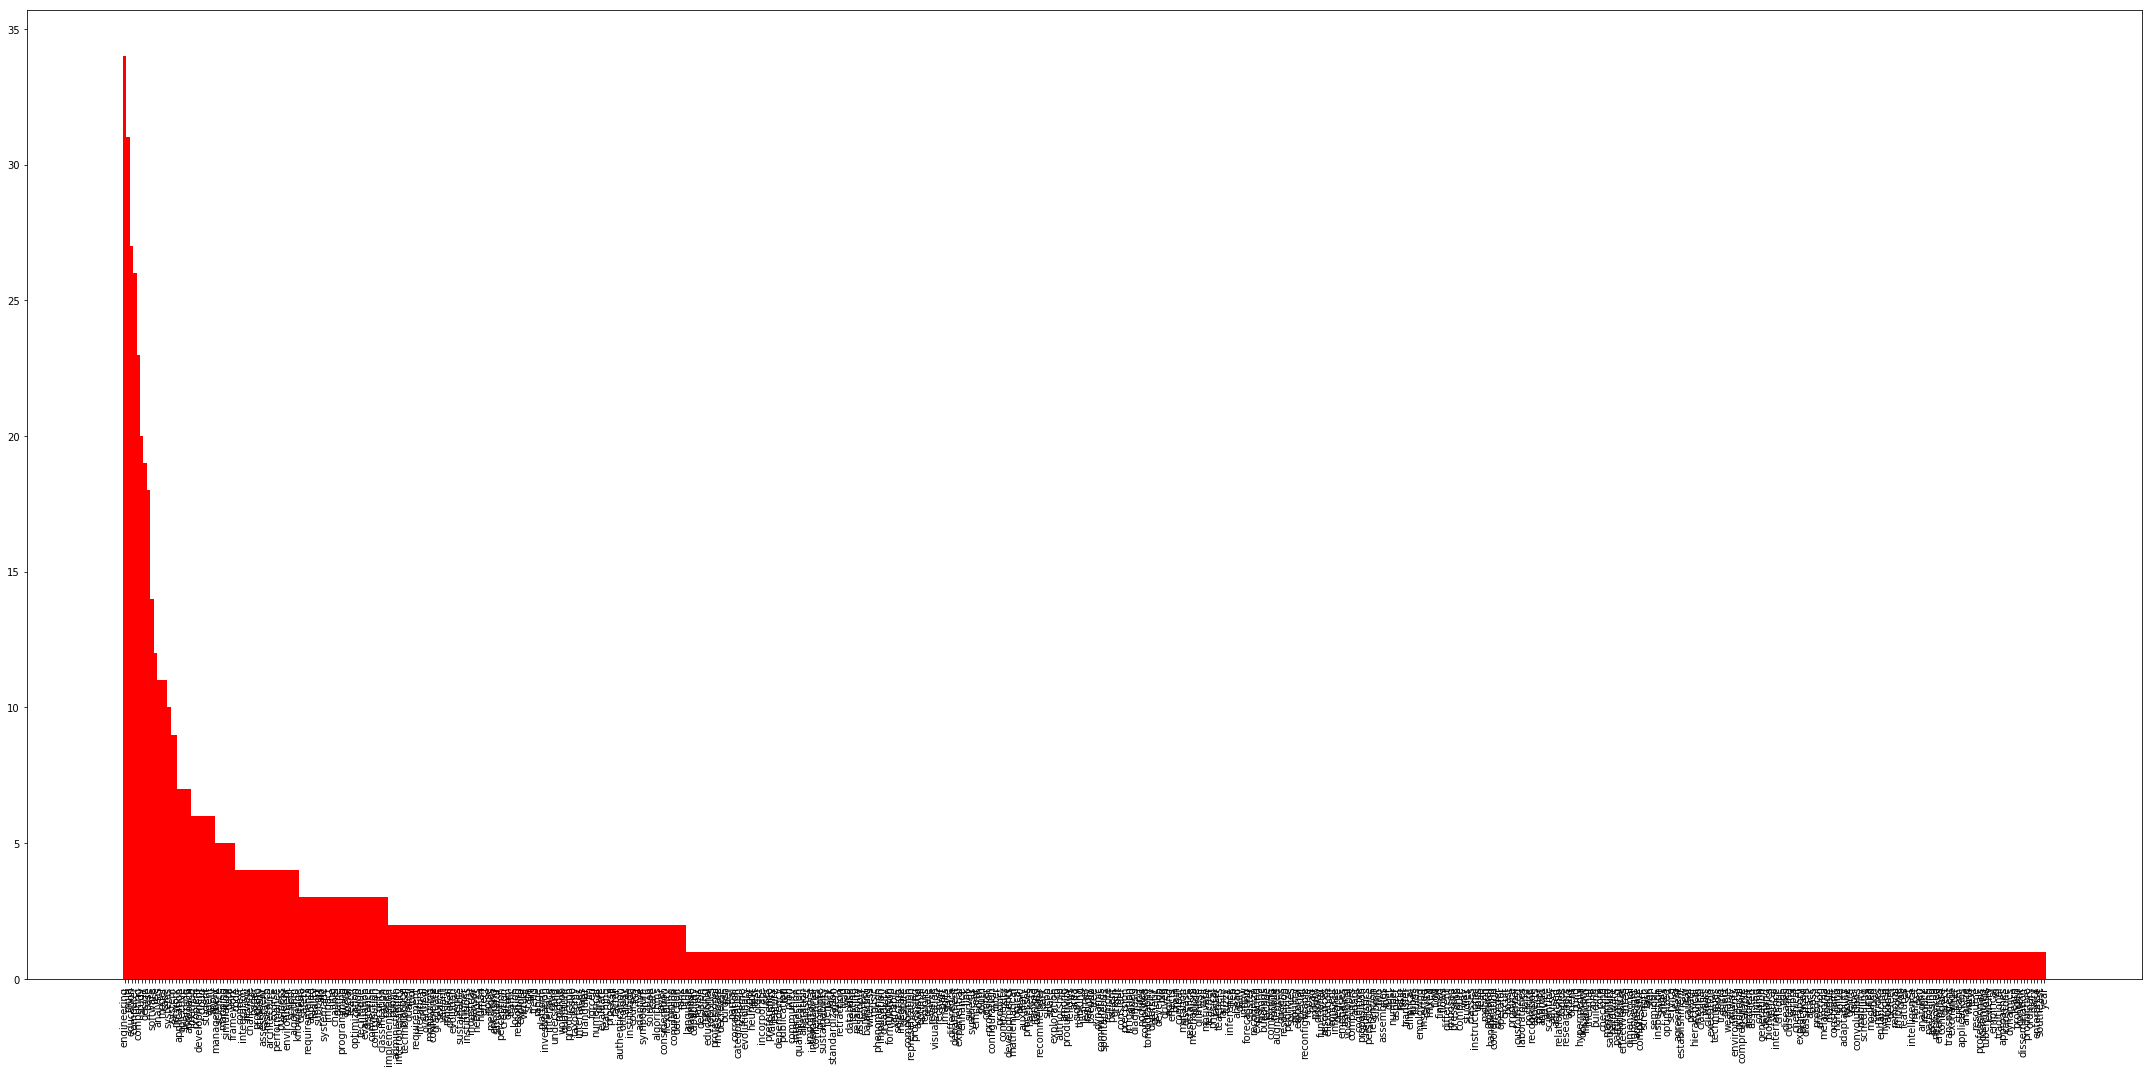

In [25]:
%matplotlib inline

word = []
frequency = []
for i in range(len(words_freq)):
    word.append(words_freq[i][0])
    frequency.append(words_freq[i][1])
plt.figure(figsize=(30, 15))
plt.bar(indices,frequency,width =1, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()


In [26]:
f = open('../acm_words.txt','r')
acm_words = f.read().replace('\n',' ').split()

In [27]:
stop_words_without_acm_words = list(set(word) - set(acm_words))

In [28]:
# TF-IDF
max_df = 0.85
min_df = 0.01
ngram= (1,1)
#NMF
n_components = 60
n_topics = 10
# STOC
#n_final = 30

In [29]:
tfidf,tfidf_feature_names = execute_tfidf(artigos,max_df=max_df,min_df=min_df,ngram=ngram,stop_words = stop_words_without_acm_words)

In [30]:
nmf,W,H = execute_nmf(n_components=n_components,n_topics=n_topics,tfidf=tfidf)

In [33]:
topics_nmf,a = print_top_words_display(H.transpose(), tfidf_feature_names,n_topics)

Topic,topwords
Topic # 0,design noise rank range algorithms channel numerical optimization education base
Topic # 1,engineering critical evolution simulation process reality ontology science system based
Topic # 2,computing human social middle performance quantum solution simulation framework applied
Topic # 3,multi optimization integration energy architecture requirements layer location algorithms agent
Topic # 4,education code student distance quality children mining game methods line
Topic # 5,computer performance algorithm simulator care vision series detection interface program
Topic # 6,analysis energy requirements interface literature integration quality environment science use
Topic # 7,base line performance monitoring search layer time student management ontology
Topic # 8,interface methods computer game analysis systems application software vision evaluation
Topic # 9,network location energy virtual layer distance algorithms knowledge application social


In [51]:
def area_parents(area,areas_id,areas_parents,similar_area):
    li_id = getKeysByValue(areas_id,area)
    parents = [areas_parents[i] for i in li_id]
    for li in li_id:
        if li not in similar_area.keys():
            similar_area[li] = 1
        else:
            similar_area[li] += 1
    for parent in parents:
        for p in parent:
            if p not in similar_area.keys():
                similar_area[p] =1
            else:
                similar_area[p] +=1
                
        #print(area+"-->"+"-->".join([areas_id[i] for i in parent][::-1]))
    return similar_area
def topic_acm_area(topic,areas_id,areas_parents):
    similar_area = {}
    print(topic)
    m = 0
    for area in [areas_id[j] for j in y]:
        a = fuzz.partial_token_set_ratio(area,topic)
        if a > m:
            m = a
            s = area
        
             #area_parents(area,areas_id,areas_parents,similar_area)
    print(s)
    return similar_area
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return  listOfKeys

In [36]:
with open('../../datasets/'+ 'acm_hierachy' + '.pkl', 'rb') as f:
    acm = pickle.load(f)
with open('../../datasets/'+ 'acm_areas' + '.pkl', 'rb') as f:
    areas = pickle.load(f)
with open('../../datasets/'+ 'acm_areas_id' + '.pkl', 'rb') as f:
    areas_id = pickle.load(f)
with open('../../datasets/'+ 'acm_areas_parents' + '.pkl', 'rb') as f:
    areas_parents = pickle.load(f)

In [44]:
idx = getKeysByValue(areas_id,'software and its engineering')
y = []
for i in areas_parents:
    value = areas_parents[i]
    if idx[0] in value:
        if len(value) == 1: # Hieirarquias
            y.append(i)
[areas_id[j] for j in y]

['software organization and properties',
 'software notations and tools',
 'software creation and management']

In [52]:
table = []
for idx,topic in enumerate(topics_nmf):
    similar_area = topic_acm_area(topic,areas_id,areas_parents)
    print("---------------------------------------")
    print("\n")
    if similar_area.items():
        maior = 0
        for value in similar_area:
#             if not len(areas_parents[value]) == 0:
            if similar_area[value] > maior:
                maior = similar_area[value]
        for i in getKeysByValue(similar_area,maior):
            if len(areas_parents[i]) == 0:
                result = areas_id[i]
            
        print(result)
        table.append([idx,topic,result])

design noise rank range algorithms channel numerical optimization education base
software organization and properties
---------------------------------------


engineering critical evolution simulation process reality ontology science system based
software notations and tools
---------------------------------------


computing human social middle performance quantum solution simulation framework applied
software notations and tools
---------------------------------------


multi optimization integration energy architecture requirements layer location algorithms agent
software notations and tools
---------------------------------------


education code student distance quality children mining game methods line
software creation and management
---------------------------------------


computer performance algorithm simulator care vision series detection interface program
software notations and tools
---------------------------------------


analysis energy requirements interface literatu

software creation and management
---------------------------------------


based interoperability series sensor data model assessment system engineering use
software organization and properties
---------------------------------------


